In [8]:
from pyspark.sql.functions import lit
from pyspark.sql import SparkSession
from pyspark import SparkContext
import json
import os
from pyspark.sql.functions import to_timestamp, substring
from pyspark.sql.functions import explode, col, unix_timestamp
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType, LongType
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd
spark = SparkSession.builder.appName("CapstoneSession").getOrCreate()

# Data Engineering Capstone Project
### Summary
FOREX data and Stockmarket data from different data sources will be collected and loaded into Data Lake in Apache Spark. The data can be used to backtest trading strategies, investigate correlations of stocks and currency or between each other as well as visualizations. Moreover indicators can be added to the data model.
The project was done in the following steps:
- Describe and Collect the Data
- Explore and Asses the Data
- Define the Data Model
- Run ETL to model the Data
- Example application

## Describe and Collect the Data
The stock market data was collected by using an API and downloaded into JSON format. The currency data was downloaded in CSV files.

In [ ]:
# download data from Marketstack API
# skip this part, since already downloaded to /data/stocks/list

# parameters
api_key = 'add your api key here...'
exchanges_url = "https://api.marketstack.com/v1/exchanges/XTKS/tickers"
eod_url = "https://api.marketstack.com/v1/eod"

exchanges_params = {
    'access_key' : api_key,
    'limit' : 10000
}
eod_params = {
    'symbols' : 'MSFT',
    'limit' : '10000',
    'access_key' : api_key,
    'date_from' : '2006-01-01',
    'date_to' : '2020-07-15',
    'sort' : 'ASC'
}

# where to save the json files
# ran this part three times, once for each market XTKS, XNYS, XNAS
# get all stock symbols from the exchange
response = requests.get(exchanges_url, exchanges_params)
response.status_code
raw_tickers = response.json()['data']['tickers']
xtks_stocks = [stock['symbol'] for stock in raw_tickers]

# save path 
rel_path = os.getcwd()+'/data/stocks/XTKS/'

i = 0
n = len(xtks_stocks)
for stock in xtks_stocks:
    eod_params['symbols'] = stock
    print(f"Process file {i} of {n} ...")
    print(f"Download {stock} stock")
    response = requests.get(eod_url, eod_params)
    print(f"Status {response.status_code}")
    if stock.find('/') >= 0:
        stock = stock.replace('/', '_')
    with open(f"{rel_path}{stock}.json", 'w') as outputfile:
        json.dump(response.json(), outputfile)
    print(f"Saved data/stocks/XTKS/{stock}.json\n")
    i += 1
    
# The CSV files where downloaded by hand at
# https://eaforexacademy.com/software/forex-historical-data/

## Explore and Assess the Data

In [3]:
# load one JSON file to understand the data schema
os.listdir(os.getcwd()+"/data/stocks/list")

['HQH.json',
 'BKEPP.json',
 'AGRX.json',
 'RBBR.json',
 'MIE.json',
 '7635.XTKS.json',
 'ILI.json',
 'NTR.json',
 'ANBC.json',
 '3405.XTKS.json',
 'FMCO.json',
 'NCC.json',
 'ACN1.json',
 'SUSL.json',
 '8275.XTKS.json',
 'PAM1.json',
 'DVID.json',
 'MPWR1.json',
 'ALUS1.json',
 '6184.XTKS.json',
 '7287.XTKS.json',
 'NATI.json',
 '8167.XTKS.json',
 'QGEN.json',
 '4450.XTKS.json',
 'DGRW.json',
 'CAM.json',
 'GALTU.json',
 'IVENC.json',
 '3279.XTKS.json',
 'HRZN.json',
 'MDMD.json',
 'AMEP.json',
 'EGLS.json',
 '3577.XTKS.json',
 'VIP.json',
 '2754.XTKS.json',
 'OSB.json',
 'AXS-P-D.json',
 'JOSB.json',
 'CHOPF.json',
 'CAMBU.json',
 'VIBC.json',
 'VGR.json',
 'FPL.json',
 'JMDT.json',
 '7855.XTKS.json',
 'HQSM.json',
 '7862.XTKS.json',
 'MCBK.json',
 'SRCI.json',
 'NTEC1.json',
 '7961.XTKS.json',
 'SGI.json',
 'SWLH.json',
 'PYX.json',
 'BIOC1.json',
 'GLP.json',
 '3246.XTKS.json',
 'HLYS.json',
 'FOXA-V.json',
 'AGS.json',
 'FCNCA.json',
 'CLUB.json',
 'ALLP.json',
 '7624.XTKS.json',


In [5]:
# Take MSFT.json for example
with open(os.getcwd()+"/data/stocks/list/MSFT.json") as f:
    data = json.load(f)['data']

In [7]:
data[0]

{'open': 26.25,
 'high': 27.001,
 'low': 26.1,
 'close': 26.84,
 'volume': 79973000.0,
 'adj_high': 19.7239775153,
 'adj_low': 19.0658054571,
 'adj_close': 19.6063685237,
 'adj_open': 19.1753790517,
 'adj_volume': 79973000.0,
 'symbol': 'MSFT',
 'exchange': 'XNAS',
 'date': '2006-01-03T00:00:00+0000'}

In [9]:
os.listdir(os.getcwd()+"/data/forex")

['EURUSD_D1.csv',
 'USDCAD_D1.csv',
 'XAGUSD_D1.csv',
 'XAUUSD_D1.csv',
 'EURJPY_D1.csv',
 'USDJPY_D1.csv',
 'EURGBP_D1.csv',
 'EURCHF_D1.csv']

In [14]:
# Do the same for the FOREX data
data = pd.read_csv("./data/forex/EURUSD_D1.csv", delimiter= "\t")
data.head()

,Time,Open,High,Low,Close,Volume
0,2007-01-01 00:00:00,1.31908,1.32176,1.31650,1.32120,1995282
1,2007-01-02 00:00:00,1.32137,1.32951,1.32101,1.32724,2009661
2,2007-01-03 00:00:00,1.32702,1.32903,1.31461,1.31690,2016603
3,2007-01-04 00:00:00,1.31689,1.31783,1.30704,1.30860,2007990
4,2007-01-05 00:00:00,1.30866,1.31029,1.29804,1.29995,1916561


In [15]:
# Both data schemas are compatible, and will be chosen according to the FOREX

## Define the Data Model
### Fact Table - Ticker and Indicator Data
- ticker_id - Integer value of the specific stock/currency
- timestamp - Long Integer of the Date of the price
- symbol - String value of the Stock symbol which is mapped to the ticker_id
- volume - Double value of the volume of the current stock/currency at the date
- type - String value of the type of price, high, low, close, open, return 
- indicator - String of the indicator, currently only sma

### Dimension Tables
#### Symbol Table
- ticker_id
- symbol
- exchange
- type

#### Price Table
- ticker_id - Integer value of the stock
- timestamp - Long Integer value of the date
- high - Double of the highest value at that date
- low - Double of the lowest value at that date
- open - Double value of the open price at that date
- close - Double value of the close price at that date
- return

#### sma table
- ticker_id - Integer value of the stock
- timestamp - Long Integer value of the date
- price - Double value of the SMA value of the ticker
- sma_interval - Integer value of the SMA interval, currently only 3, 5, 8, 10, 12, 15, 30, 35, 40, 45, 50, 60 added

## Run ETL to model the Data

In [17]:
# the schemas for the table used in the ETL pipeline
price_schema = StructType([
    StructField('close', DoubleType(), True),
    StructField('high', DoubleType(), True),
    StructField('low', DoubleType(), True),
    StructField('open', DoubleType(), True),
    StructField('volume', DoubleType(), True),
    StructField('timestamp', LongType(), True),
    StructField('return', DoubleType(), True),
    StructField('ticker_id', IntegerType(), True)
])

symbol_schema = StructType([
    StructField('ticker_id', IntegerType(), False),
    StructField('symbol', StringType(), False),
    StructField('exchange', StringType(), False),
    StructField('type', StringType(), False)
])

forex_schema = StructType([
    StructField('time', StringType(), True),
    StructField('open', DoubleType(), True),
    StructField('high', DoubleType(), True),
    StructField('low', DoubleType(), True),
    StructField('close', DoubleType(), True),
    StructField('volume', DoubleType(), True),
])

sma_schema = StructType([
    StructField('ticker_id', IntegerType(), True),
    StructField('timestamp', LongType(), True),
    StructField('price', DoubleType(), True),
    StructField('sma_interval', IntegerType(), True),
])

In [18]:
# instanciate the tables/dataframes
stocks_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), price_schema)
stocks_df.printSchema()

symbols_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), symbol_schema)
symbols_df.printSchema()

sma_df = sma_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), sma_schema)
sma_df.printSchema()

root
 |-- close: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- open: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- return: double (nullable = true)
 |-- ticker_id: integer (nullable = true)

root
 |-- ticker_id: integer (nullable = false)
 |-- symbol: string (nullable = false)
 |-- exchange: string (nullable = false)
 |-- type: string (nullable = false)

root
 |-- ticker_id: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- price: double (nullable = true)
 |-- sma_interval: integer (nullable = true)



In [ ]:
# start with the stocks first ...
#add the stock data to the price table
rel_path = os.getcwd()+'/data/stocks/list/'
tickerlist = os.listdir(rel_path)

index = 0
for ticker in tickerlist:
    # read the json file into spark
    data = spark.read.json(rel_path+ticker)
    
    # check for empty ticker
    if data.select('pagination.count').collect()[0]['count'] == 0:
        continue
    
    # extract the important columns
    temp_df = data.select(explode(data.data)).select(['col.adj_close','col.adj_high','col.adj_low','col.adj_open','col.adj_volume','col.date', 'col.symbol', 'col.exchange'])
    temp_df = temp_df.withColumn("temp", substring(temp_df.date, 0, 10)).drop("date").withColumn("timestamp", unix_timestamp("temp", "yyyy-MM-dd")).drop("temp")
    # calculate return
    price_window = Window.partitionBy().orderBy("timestamp")
    temp_df = temp_df.withColumn("prev_close", F.lag(temp_df.adj_close).over(price_window))
    temp_df = temp_df.withColumn("return", F.when(F.isnull(temp_df.adj_close - temp_df.prev_close), 0).otherwise((temp_df.adj_close - temp_df.prev_close)/temp_df.prev_close))
    temp_df = temp_df.withColumn('ticker_id', lit(index))
    temp_df = temp_df.drop('date')
    symbol = temp_df.select('symbol').collect()[0]['symbol']
    exchange = temp_df.select('exchange').collect()[0]['exchange']
    temp_df = temp_df.drop('symbol')
    temp_df = temp_df.drop('exchange')
    temp_df = temp_df.drop('prev_close')
    
    # add the temp_df to the stocks_df
    stocks_df = stocks_df.union(temp_df)
    
    # add a new row to the symbols_df
    temp2_df = spark.createDataFrame([(index,symbol,exchange,'stocks')], symbol_schema)
    symbols_df = symbols_df.union(temp2_df)
    
    # status
    print(f"Extracted {symbol} as ticker_id {index}...")
    
    # increment the index
    index += 1
    
    # write parquet file every 100 entries ...
    if index % 100 == 0:
        stocks_df.write.mode('append').partitionBy('ticker_id').parquet('./data/parq/stocks/')
        # delete the current entries
        stocks_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), price_schema)

        symbols_df.write.mode('append').partitionBy('ticker_id').parquet('./data/parq/symbols/')
        # delete the current entries
        symbols_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), symbol_schema)


# rest of the data        
stocks_df.write.mode('append').partitionBy('ticker_id').parquet('./data/parq/stocks/')
# delete the current entries
stocks_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), price_schema)

symbols_df.write.mode('append').partitionBy('ticker_id').parquet('./data/parq/symbols/')
# delete the current entries
symbols_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), symbol_schema)

In [ ]:
#add the currency data to the price table
forex_path = os.getcwd()+'/data/forex/'
cpairs = os.listdir(forex_path)

for cpair in cpairs:
    data = spark.read.schema(forex_schema).option("header","true").option("delimiter","\t").csv(forex_path+cpair)
    # extract the important columns
    temp_df = data.select(['close','high','low','open','volume','time'])
    temp_df = temp_df.withColumn("date", substring(temp_df.time, 0, 10)).drop("time").withColumn("timestamp", unix_timestamp("date", "yyyy-MM-dd")).drop("date")
    # calculate return
    price_window = Window.partitionBy().orderBy("timestamp")
    temp_df = temp_df.withColumn("prev_close", F.lag(temp_df.close).over(price_window))
    temp_df = temp_df.withColumn("return", F.when(F.isnull(temp_df.close - temp_df.prev_close), 0).otherwise((temp_df.close - temp_df.prev_close)/temp_df.prev_close))
    temp_df = temp_df.withColumn('ticker_id', lit(index))
    temp_df = temp_df.drop('prev_close')
    symbol = cpair[:6]
    exchange = "FOREX"
    
    # add the temp_df to the stocks_df
    stocks_df = stocks_df.union(temp_df)

    # add a new row to the symbols_df
    temp2_df = spark.createDataFrame([(index,symbol,exchange,'currency')], symbol_schema)
    symbols_df = symbols_df.union(temp2_df)
    
    # status
    print(f"Extracted {symbol} as ticker_id {index}...")
    
    # increment the index
    index += 1
    
# rest of the data        
stocks_df.write.mode('append').partitionBy('ticker_id').parquet('./data/parq/stocks/')
# delete the current entries
stocks_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), price_schema)

symbols_df.write.mode('append').partitionBy('ticker_id').parquet('./data/parq/symbols/')
# delete the current entries
symbols_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), symbol_schema)

In [19]:
# define a function for the SMA table
def SMA(df, ts_name, price_col, new_col, n):
    windowSpec = Window.orderBy(F.col(ts_name).cast('long')).rangeBetween(-86400*n, 0)
    return df.withColumn(new_col, F.avg("close").over(windowSpec))

In [20]:
# read the stock data from the price table
stocks_table = spark.read.parquet('./data/parq/stocks/')
# check how many data points are there ...
stocks_table.count()

30678648

In [22]:
# create a temporary view for SQL style access
stocks_table.createOrReplaceTempView("stocks_tbl")
# count the tickers
totals = spark.sql(f'''
SELECT DISTINCT(ticker_id) AS total
FROM stocks_tbl
''').count()

In [128]:
# create the SMA table
# hence this takes really long...
# limited to 500, normally to "totals"
# calculate a collection of Simple Moving Averages
smas = [3, 5, 8, 10, 12, 15, 30, 35, 40, 45, 50, 60]

for i in range(0,100):
    for current_sma in smas:

        temp_df = SMA(spark.sql(f'''
        SELECT ticker_id, timestamp, close
        FROM stocks_tbl
        WHERE ticker_id == {i}
        '''), "timestamp", "close", f"SMA{current_sma}", current_sma)
    
        temp_df = temp_df.withColumn('SMA_interval', lit(current_sma)).drop('close')
    
        # add the temp_df to the stocks_df
        sma_df = sma_df.unionAll(temp_df)
    
        print(f"Created SMA{current_sma} for ticker id: {i}")

    # write parquet file every 20 entries ...
    if (i>0 and i % 19 == 0):
        sma_df.write.mode('append').partitionBy('sma_interval','ticker_id').parquet('./data/parq/sma/')
        # create empy sma_df
        sma_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), sma_df.schema)

sma_df.write.mode('append').partitionBy('sma_interval','ticker_id').parquet('./data/parq/sma/')
# create empy sma_df
sma_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), sma_df.schema)

Created SMA3 for ticker id: 0
Created SMA5 for ticker id: 0
Created SMA8 for ticker id: 0
Created SMA10 for ticker id: 0
Created SMA12 for ticker id: 0
Created SMA15 for ticker id: 0
Created SMA30 for ticker id: 0
Created SMA35 for ticker id: 0
Created SMA40 for ticker id: 0
Created SMA45 for ticker id: 0
Created SMA50 for ticker id: 0
Created SMA60 for ticker id: 0
Created SMA3 for ticker id: 1
Created SMA5 for ticker id: 1
Created SMA8 for ticker id: 1
Created SMA10 for ticker id: 1
Created SMA12 for ticker id: 1
Created SMA15 for ticker id: 1
Created SMA30 for ticker id: 1
Created SMA35 for ticker id: 1
Created SMA40 for ticker id: 1
Created SMA45 for ticker id: 1
Created SMA50 for ticker id: 1
Created SMA60 for ticker id: 1
Created SMA3 for ticker id: 2
Created SMA5 for ticker id: 2
Created SMA8 for ticker id: 2
Created SMA10 for ticker id: 2
Created SMA12 for ticker id: 2
Created SMA15 for ticker id: 2
Created SMA30 for ticker id: 2
Created SMA35 for ticker id: 2
Created SMA40 for

Created SMA8 for ticker id: 22
Created SMA10 for ticker id: 22
Created SMA12 for ticker id: 22
Created SMA15 for ticker id: 22
Created SMA30 for ticker id: 22
Created SMA35 for ticker id: 22
Created SMA40 for ticker id: 22
Created SMA45 for ticker id: 22
Created SMA50 for ticker id: 22
Created SMA60 for ticker id: 22
Created SMA3 for ticker id: 23
Created SMA5 for ticker id: 23
Created SMA8 for ticker id: 23
Created SMA10 for ticker id: 23
Created SMA12 for ticker id: 23
Created SMA15 for ticker id: 23
Created SMA30 for ticker id: 23
Created SMA35 for ticker id: 23
Created SMA40 for ticker id: 23
Created SMA45 for ticker id: 23
Created SMA50 for ticker id: 23
Created SMA60 for ticker id: 23
Created SMA3 for ticker id: 24
Created SMA5 for ticker id: 24
Created SMA8 for ticker id: 24
Created SMA10 for ticker id: 24
Created SMA12 for ticker id: 24
Created SMA15 for ticker id: 24
Created SMA30 for ticker id: 24
Created SMA35 for ticker id: 24
Created SMA40 for ticker id: 24
Created SMA45 f

Created SMA8 for ticker id: 44
Created SMA10 for ticker id: 44
Created SMA12 for ticker id: 44
Created SMA15 for ticker id: 44
Created SMA30 for ticker id: 44
Created SMA35 for ticker id: 44
Created SMA40 for ticker id: 44
Created SMA45 for ticker id: 44
Created SMA50 for ticker id: 44
Created SMA60 for ticker id: 44
Created SMA3 for ticker id: 45
Created SMA5 for ticker id: 45
Created SMA8 for ticker id: 45
Created SMA10 for ticker id: 45
Created SMA12 for ticker id: 45
Created SMA15 for ticker id: 45
Created SMA30 for ticker id: 45
Created SMA35 for ticker id: 45
Created SMA40 for ticker id: 45
Created SMA45 for ticker id: 45
Created SMA50 for ticker id: 45
Created SMA60 for ticker id: 45
Created SMA3 for ticker id: 46
Created SMA5 for ticker id: 46
Created SMA8 for ticker id: 46
Created SMA10 for ticker id: 46
Created SMA12 for ticker id: 46
Created SMA15 for ticker id: 46
Created SMA30 for ticker id: 46
Created SMA35 for ticker id: 46
Created SMA40 for ticker id: 46
Created SMA45 f

Created SMA50 for ticker id: 65
Created SMA60 for ticker id: 65
Created SMA3 for ticker id: 66
Created SMA5 for ticker id: 66
Created SMA8 for ticker id: 66
Created SMA10 for ticker id: 66
Created SMA12 for ticker id: 66
Created SMA15 for ticker id: 66
Created SMA30 for ticker id: 66
Created SMA35 for ticker id: 66
Created SMA40 for ticker id: 66
Created SMA45 for ticker id: 66
Created SMA50 for ticker id: 66
Created SMA60 for ticker id: 66
Created SMA3 for ticker id: 67
Created SMA5 for ticker id: 67
Created SMA8 for ticker id: 67
Created SMA10 for ticker id: 67
Created SMA12 for ticker id: 67
Created SMA15 for ticker id: 67
Created SMA30 for ticker id: 67
Created SMA35 for ticker id: 67
Created SMA40 for ticker id: 67
Created SMA45 for ticker id: 67
Created SMA50 for ticker id: 67
Created SMA60 for ticker id: 67
Created SMA3 for ticker id: 68
Created SMA5 for ticker id: 68
Created SMA8 for ticker id: 68
Created SMA10 for ticker id: 68
Created SMA12 for ticker id: 68
Created SMA15 for

Created SMA15 for ticker id: 87
Created SMA30 for ticker id: 87
Created SMA35 for ticker id: 87
Created SMA40 for ticker id: 87
Created SMA45 for ticker id: 87
Created SMA50 for ticker id: 87
Created SMA60 for ticker id: 87
Created SMA3 for ticker id: 88
Created SMA5 for ticker id: 88
Created SMA8 for ticker id: 88
Created SMA10 for ticker id: 88
Created SMA12 for ticker id: 88
Created SMA15 for ticker id: 88
Created SMA30 for ticker id: 88
Created SMA35 for ticker id: 88
Created SMA40 for ticker id: 88
Created SMA45 for ticker id: 88
Created SMA50 for ticker id: 88
Created SMA60 for ticker id: 88
Created SMA3 for ticker id: 89
Created SMA5 for ticker id: 89
Created SMA8 for ticker id: 89
Created SMA10 for ticker id: 89
Created SMA12 for ticker id: 89
Created SMA15 for ticker id: 89
Created SMA30 for ticker id: 89
Created SMA35 for ticker id: 89
Created SMA40 for ticker id: 89
Created SMA45 for ticker id: 89
Created SMA50 for ticker id: 89
Created SMA60 for ticker id: 89
Created SMA3 f

In [129]:
import datetime
# create a FACT table
# choose NATI stock, from 2018-01-01 to the latest available date and SMA of 50
# load the symbols table and create a temp view
# read the symbols table
symbols_table = spark.read.parquet('./data/parq/symbols/')
symbols_table.createOrReplaceTempView("symbols_tbl")
# read the sma table and create temp view
sma_table = spark.read.parquet('./data/parq/sma/')
sma_table.createOrReplaceTempView("sma_tbl")

date_from = int(datetime.datetime(2018, 1, 1, 23, 0, 0, 0, tzinfo=datetime.timezone.utc).timestamp())
symbol = 'NATI'
sma_interval = 50

In [197]:
close_ = spark.sql(f"SELECT price.timestamp AS date, price.close \
            FROM stocks_tbl price \
            WHERE price.ticker_id == (SELECT ticker_id as ticker FROM symbols_tbl WHERE symbol == '{symbol}') \
            AND price.timestamp >= {date_from} \
            ")
sma_ = spark.sql(f"SELECT sma.timestamp AS smadate, sma.price AS SMA{sma_interval} \
            FROM sma_tbl sma \
            WHERE sma.SMA_interval == {sma_interval} \
            AND sma.ticker_id == (SELECT ticker_id as ticker FROM symbols_tbl WHERE symbol == '{symbol}') \
            AND sma.timestamp >= {date_from} \
            ")

In [198]:
close_.show()

+----------+-------------+
|      date|        close|
+----------+-------------+
|1546383600|43.7611556015|
|1546470000|41.2045625163|
|1546556400|43.0086489576|
|1546815600|43.8093932069|
|1546902000|45.2758164105|
|1546988400|45.1214560732|
|1547074800|45.6231271692|
|1547161200|45.3915866634|
|1547420400|45.5845370849|
|1547506800|45.3915866634|
|1547593200|44.8609730042|
|1547679600|44.5522523298|
|1547766000|44.2531791764|
|1548111600|42.6516906777|
|1548198000|42.2561423136|
|1548284400|43.3559597163|
|1548370800|43.5971477432|
|1548630000|43.1051241683|
|1548716400|43.2980745898|
|1548802800|41.6579960069|
+----------+-------------+
only showing top 20 rows



In [199]:
sma_.show()

+----------+------------------+
|   smadate|             SMA50|
+----------+------------------+
|1546383600| 45.11736318552121|
|1546470000| 44.95189358160909|
|1546556400|  44.8472325953909|
|1546815600|44.615262701787486|
|1546902000| 44.63527948083938|
|1546988400|44.599028189521206|
|1547074800|44.608091012351515|
|1547161200| 44.61072215446364|
|1547420400| 44.62884780012121|
|1547506800|44.651281296099995|
|1547593200| 44.62999999960883|
|1547679600|44.601908688241174|
|1547766000|    44.52784977645|
|1548111600| 44.31106430285455|
|1548198000| 44.13945536734848|
|1548284400| 44.02310041618789|
|1548370800|44.010572396394124|
|1548630000| 43.86406249299091|
|1548716400| 43.84741578995589|
|1548802800| 43.72824052960295|
+----------+------------------+
only showing top 20 rows



In [202]:
fact_tbl = close_.join(sma_, close_.date == sma_.smadate).withColumn('symbol', lit(symbol)).drop('smadate').orderBy(col('date'))

In [203]:
fact_tbl.show()

+----------+-------------+------------------+------+
|      date|        close|             SMA50|symbol|
+----------+-------------+------------------+------+
|1546383600|43.7611556015| 45.11736318552121|  NATI|
|1546470000|41.2045625163| 44.95189358160909|  NATI|
|1546556400|43.0086489576|  44.8472325953909|  NATI|
|1546815600|43.8093932069|44.615262701787486|  NATI|
|1546902000|45.2758164105| 44.63527948083938|  NATI|
|1546988400|45.1214560732|44.599028189521206|  NATI|
|1547074800|45.6231271692|44.608091012351515|  NATI|
|1547161200|45.3915866634| 44.61072215446364|  NATI|
|1547420400|45.5845370849| 44.62884780012121|  NATI|
|1547506800|45.3915866634|44.651281296099995|  NATI|
|1547593200|44.8609730042| 44.62999999960883|  NATI|
|1547679600|44.5522523298|44.601908688241174|  NATI|
|1547766000|44.2531791764|    44.52784977645|  NATI|
|1548111600|42.6516906777| 44.31106430285455|  NATI|
|1548198000|42.2561423136| 44.13945536734848|  NATI|
|1548284400|43.3559597163| 44.02310041618789| 

## Example application

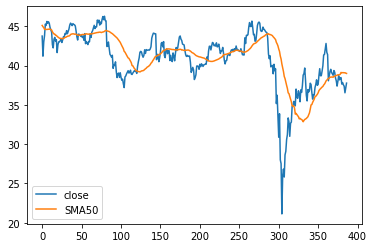

In [204]:
# first print the close and sma price
fact_tbl.select('close', 'SMA50').toPandas().plot()

In [275]:
date_from = int(datetime.datetime(2019, 1, 1, 23, 0, 0, 0, tzinfo=datetime.timezone.utc).timestamp())
sma_interval = 3

In [276]:
def get_SMA_col(df, ticker_id, n, timestamp):
    return df.filter(f"ticker_id == {ticker_id} and SMA_interval == {n} and timestamp >= {timestamp}").select('timestamp','price').toDF(f"date{n}", f"SMA{n}")

In [277]:
# select all available SMAs, that would build up the so called GUPPY indicator...
close_ = spark.sql(f"SELECT price.timestamp AS date, price.close \
            FROM stocks_tbl price \
            WHERE price.ticker_id == (SELECT ticker_id as ticker FROM symbols_tbl WHERE symbol == '{symbol}') \
            AND price.timestamp >= {date_from} \
            ")
sma_ = spark.sql(f"SELECT sma.timestamp AS smadate, sma.price AS SMA{sma_interval}, sma.ticker_id AS ticker \
            FROM sma_tbl sma \
            WHERE sma.SMA_interval == {sma_interval} \
            AND sma.ticker_id == (SELECT ticker_id as ticker FROM symbols_tbl WHERE symbol == '{symbol}') \
            AND sma.timestamp >= {date_from} \
            ")

In [278]:
sma_.show()


+----------+------------------+------+
|   smadate|              SMA3|ticker|
+----------+------------------+------+
|1546383600|     43.7708031226|    11|
|1546470000|42.915389587166665|    11|
|1546556400| 42.65812235846667|    11|
|1546815600|    43.40902108225|    11|
|1546902000|     44.5426048087|    11|
|1546988400|     44.7355552302|    11|
|1547074800|44.957448214950006|    11|
|1547161200|   45.352996579075|    11|
|1547420400|    45.48806187415|    11|
|1547506800|    45.48806187415|    11|
|1547593200| 45.27903225083333|    11|
|1547679600|   45.097337270575|    11|
|1547766000|44.764497793450005|    11|
|1548111600|     42.6516906777|    11|
|1548198000|42.453916495650006|    11|
|1548284400|     42.7545975692|    11|
|1548370800|     42.9652351127|    11|
|1548630000|43.351135955749996|    11|
|1548716400|    43.20159937905|    11|
|1548802800| 42.68706492166667|    11|
+----------+------------------+------+
only showing top 20 rows



In [279]:
smas = [5, 8, 10, 12, 15, 30, 35, 40, 45, 50, 60]

In [280]:
smas_df = get_SMA_col(sma_table, 11, 3, date_from)

In [281]:
for n in smas:
    temp = get_SMA_col(sma_table, 11, n, date_from)
    smas_df = smas_df.join(temp, smas_df["date3"] == temp[f"date{n}"]).drop(f"date{n}")

In [282]:
full_df = close_.join(smas_df, smas_df["date3"] == close_.date).orderBy("date").drop("date3", "date").toPandas()

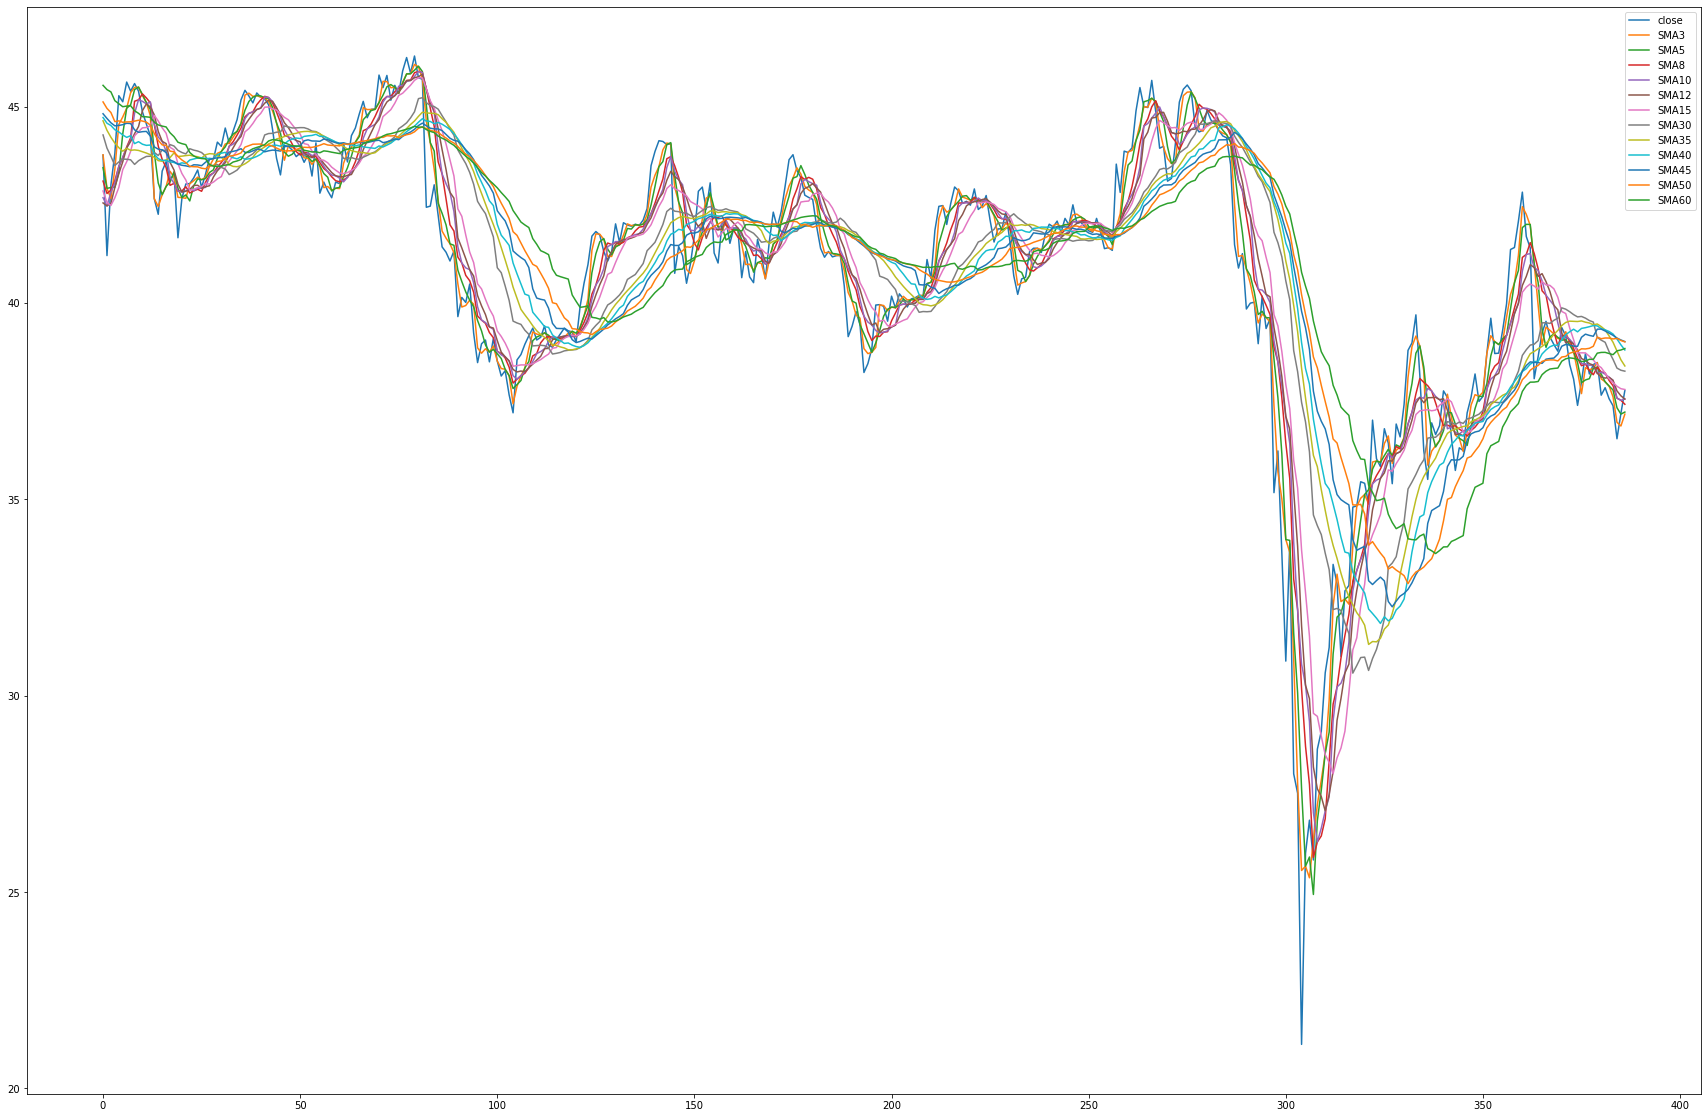

In [285]:
full_df.plot(figsize = (30,20))

In [286]:
# furthermore we could use SparkML to implement linear regression or using corr() method and find correlations of all the stocks and currencies in the data lake